In [1]:
import os
import pandas as pd
import numpy as np
#visualisation
import seaborn as sn
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
# NLP
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

### Data Acquisition

In [2]:
home_path = os.path.expanduser("~")
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/learn-ai-bbc/BBC News Train.csv'
df = pd.read_csv(fp)
df.sample(5, random_state=59)

,ArticleId,Text,Category
286,1517,falconer rebuts charade claims concessions o...,politics
1370,2112,warning over windows word files writing a micr...,tech
1483,1904,beastie boys win sampling battle us rappers be...,entertainment
487,317,takeover offer for sunderland fc bob murray c...,business
708,18,connors boost for british tennis former world ...,sport


EDA

sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: Category, dtype: float64

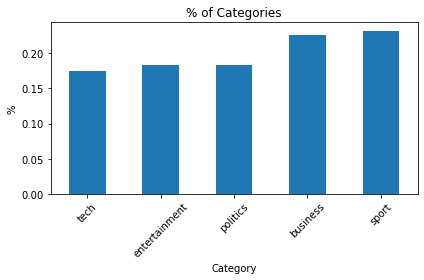

In [3]:
(f'Number of documents in dataset: {len(df)}')
display(df['Category'].value_counts()/df.shape[0]) 
# Class distribution in the dataset
plt.figure(figsize=(6,4))
(df.groupby('Category').size().sort_values()/df.shape[0]).plot.bar()
plt.title('% of Categories')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/training_categories.png')
plt.show()

In [4]:
df.shape

(1490, 3)

How many words on average per category

In [5]:
d = {}
for col in df['Category'].unique():
    df_col = df[df['Category'] == col]
    word_count = (np.mean(df_col['Text']\
                          .apply(lambda x: len(set(x.split())))))
    d[col] = word_count
d

{'business': 192.07738095238096,
 'tech': 258.4597701149425,
 'politics': 235.21167883211677,
 'sport': 189.77456647398844,
 'entertainment': 190.6959706959707}

### Pre-processing

Count non text characters

In [6]:
import re
categories = df.groupby('Category')
for category in df.Category.unique():
    corpus = ' '.join(categories.get_group(category)['Text'])
    regexp = re.compile('[^a-z A-Z]+') # ^ means not a-z or A-Z or ' ' important to include the space!
    punc = [string for text in corpus for string in text if regexp.search(string)]
    print(f'Number of non-character text in {category}: {len(punc)}')

Number of non-character text in business: 20348
Number of non-character text in tech: 15217
Number of non-character text in politics: 12242
Number of non-character text in sport: 15187
Number of non-character text in entertainment: 12553


In [7]:
# ! python -m spacy download en_core_web_sm

In [9]:
%%time
nlp = spacy.load("en_core_web_sm")

def clean(doc):
    return " ".join(token.lemma_ for token in nlp(doc)\
                   if not token.is_stop and token.is_alpha\
                  and len(token) > 1)

df['prepro'] = df['Text'].apply(clean)

CPU times: user 1min 9s, sys: 489 ms, total: 1min 10s
Wall time: 1min 10s


In [10]:
df.sample(5, random_state=59)

,ArticleId,Text,Category,prepro
286,1517,falconer rebuts charade claims concessions o...,politics,falconer rebut charade claim concession bill c...
1370,2112,warning over windows word files writing a micr...,tech,warn windows word file write microsoft word do...
1483,1904,beastie boys win sampling battle us rappers be...,entertainment,beastie boy win sample battle rapper beastie b...
487,317,takeover offer for sunderland fc bob murray c...,business,takeover offer sunderland fc bob murray chairm...
708,18,connors boost for british tennis former world ...,sport,connor boost british tennis world number jimmy...


### Feature Engineering , Modelling & Accuracy Assessment

Split data into train and validation

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df['prepro'], 
                                                      df['Category'],
                                                      test_size=0.20, random_state=42)
X_train.shape, X_valid.shape

def plot_confusion_matrix(cm, classes):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    plt.figure(figsize=(6,5))
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../plots/cm_bbc.png')
    plt.show()

#### Logisitc Regression

CPU times: user 5.91 s, sys: 6.28 s, total: 12.2 s
Wall time: 1.81 s
Accuracy Training Data:  1.0


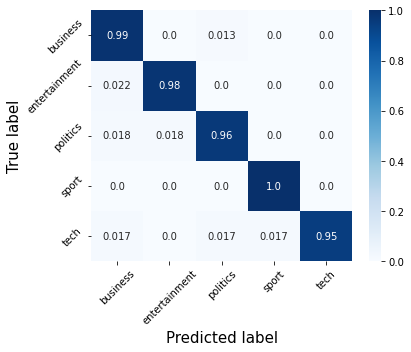

Accuracy Test Data:  0.9765100671140939
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        75
entertainment       0.98      0.98      0.98        46
     politics       0.96      0.96      0.96        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.95      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



In [13]:
pipe = Pipeline([('bow', CountVectorizer(binary=True)), 
                   ('clf', LogisticRegression(random_state=42))])
%time pipe.fit(X_train, y_train)
y_pred_training_data = pipe.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))   
    
results = pd.DataFrame()
y_pred = pipe.predict(X_valid) 
classes = pipe.classes_
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
plot_confusion_matrix(cm, classes)
accuracy =  accuracy_score(y_true=y_valid, y_pred=y_pred)
print("Accuracy Test Data: ", accuracy)
print(classification_report(y_true=y_valid, y_pred=y_pred))
results = results.append({'model': 'logistic regression', 'vec': 'bow', 'accuracy': accuracy}, ignore_index=True)

#### Support Vector Machine

CPU times: user 2.72 s, sys: 3.21 ms, total: 2.72 s
Wall time: 2.73 s
Accuracy Training Data:  1.0


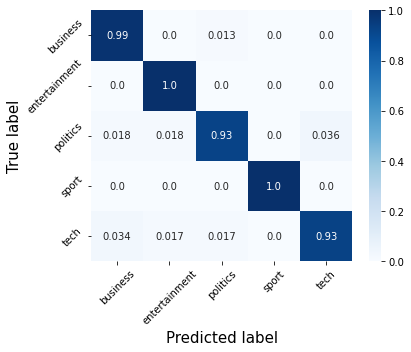

Accuracy Test Data:  0.9697986577181208
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        75
entertainment       0.96      1.00      0.98        46
     politics       0.96      0.93      0.95        56
        sport       1.00      1.00      1.00        63
         tech       0.96      0.93      0.95        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



In [14]:
pipe = Pipeline([('bow', CountVectorizer(binary=True)), 
                 ('clf', SVC(random_state=42, kernel='rbf'))])
%time pipe.fit(X_train, y_train)
y_pred_training_data = pipe.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))


y_pred = pipe.predict(X_valid) 
classes = pipe.classes_
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
plot_confusion_matrix(cm, classes)
accuracy =  accuracy_score(y_true=y_valid, y_pred=y_pred)
print("Accuracy Test Data: ", accuracy)
print(classification_report(y_true=y_valid, y_pred=y_pred))
results = results.append({'model': 'svm', 'vec': 'bow', 'accuracy': accuracy}, ignore_index=True)

CPU times: user 2.64 s, sys: 47.2 ms, total: 2.69 s
Wall time: 2.72 s
Accuracy Training Data:  1.0


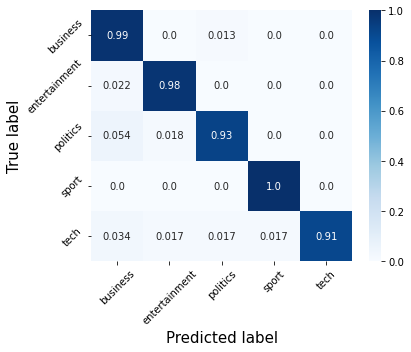

Accuracy Test Data:  0.9630872483221476
               precision    recall  f1-score   support

     business       0.93      0.99      0.95        75
entertainment       0.96      0.98      0.97        46
     politics       0.96      0.93      0.95        56
        sport       0.98      1.00      0.99        63
         tech       1.00      0.91      0.95        58

     accuracy                           0.96       298
    macro avg       0.97      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



In [15]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('clf', SVC(random_state=42, kernel='rbf'))])
%time pipe.fit(X_train, y_train)
y_pred_training_data = pipe.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))


y_pred = pipe.predict(X_valid) 
classes = pipe.classes_
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
plot_confusion_matrix(cm, classes)
accuracy =  accuracy_score(y_true=y_valid, y_pred=y_pred)
print("Accuracy Test Data: ", accuracy)
print(classification_report(y_true=y_valid, y_pred=y_pred))
results = results.append({'model': 'svm', 'vec': 'tfidf', 'accuracy': accuracy}, ignore_index=True)

#### Naive Bayes

CPU times: user 147 ms, sys: 7.55 ms, total: 155 ms
Wall time: 155 ms
Accuracy Training Data:  0.9932885906040269


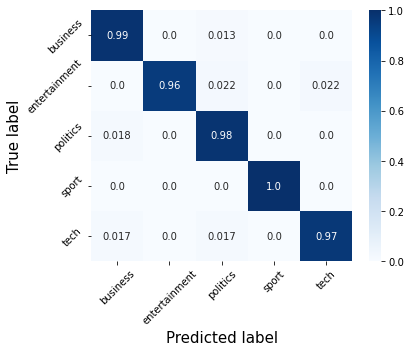

Accuracy Test Data:  0.9798657718120806
               precision    recall  f1-score   support

     business       0.97      0.99      0.98        75
entertainment       1.00      0.96      0.98        46
     politics       0.95      0.98      0.96        56
        sport       1.00      1.00      1.00        63
         tech       0.98      0.97      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



In [16]:
pipe = Pipeline([('bow', CountVectorizer(binary=True)), 
                 ('clf', MultinomialNB())])
%time pipe.fit(X_train, y_train)
y_pred_training_data = pipe.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

y_pred = pipe.predict(X_valid) 
classes = pipe.classes_
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
plot_confusion_matrix(cm, classes)
accuracy =  accuracy_score(y_true=y_valid, y_pred=y_pred)
print("Accuracy Test Data: ", accuracy)
print(classification_report(y_true=y_valid, y_pred=y_pred))
results = results.append({'model': 'naive bayes', 'vec': 'bow', 'accuracy': accuracy}, ignore_index=True)

CPU times: user 153 ms, sys: 4.1 ms, total: 157 ms
Wall time: 158 ms
Accuracy Training Data:  0.9941275167785235


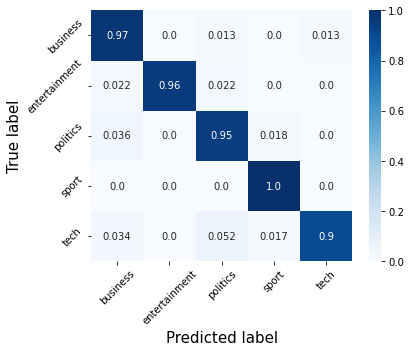

Accuracy Test Data:  0.9563758389261745
               precision    recall  f1-score   support

     business       0.94      0.97      0.95        75
entertainment       1.00      0.96      0.98        46
     politics       0.91      0.95      0.93        56
        sport       0.97      1.00      0.98        63
         tech       0.98      0.90      0.94        58

     accuracy                           0.96       298
    macro avg       0.96      0.95      0.96       298
 weighted avg       0.96      0.96      0.96       298



In [20]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('clf', MultinomialNB())])
%time pipe.fit(X_train, y_train)
y_pred_training_data = pipe.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

y_pred = pipe.predict(X_valid) 
classes = pipe.classes_
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
plot_confusion_matrix(cm, classes)
accuracy =  accuracy_score(y_true=y_valid, y_pred=y_pred)
print("Accuracy Test Data: ", accuracy)
print(classification_report(y_true=y_valid, y_pred=y_pred))
results = results.append({'model': 'naive bayes', 'vec': 'tfidf', 'accuracy': accuracy}, ignore_index=True)

In [21]:
results

,model,vec,accuracy
0,logistic regression,bow,0.976510
1,svm,bow,0.969799
2,svm,tfidf,0.963087
3,naive bayes,bow,0.979866
4,naive bayes,tfidf,0.956376


The Naive Bayes did the best! :)

In [ ]:
pipe = Pipeline([('bow', CountVectorizer(binary=True)), 
                 ('clf', MultinomialNB())])
%time pipe.fit(X_train, y_train)

### Final test dataset

In [18]:
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/learn-ai-bbc/BBC News Test.csv'
df_test = pd.read_csv(fp)
df_test['prepro'] = df_test['Text'].apply(clean)
y_pred = pipe.predict(df_test['prepro'])
df_test['Category'] = y_pred
df_test.drop(['Text', 'prepro'], axis=1).to_csv('submission.csv')

Once sent to Kaggle I found that I achieved a score of 0.97551 on the logistic regression model and a score of 0.96462 with the naive bayes model!